In [1]:
!pip install scipy
!pip install qiskit
!pip install autoray
!pip install quimb
!pip install pylatexenc
!pip install networkx==2.3
!pip install -U git+https://github.com/jcmgray/cotengra.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/jcmgray/cotengra.git to /tmp/pip-req-build-vsitng7i
  Running command git clone --filter=blob:none --quiet https://github.com/jcmgray/cotengra.git /tmp/pip-req-build-vsitng7i
  Resolved https://github.com/jcmgray/cotengra.git to commit 1a746c6483f6fdabfcf83abd5a436d0ac42921eb
 

In [218]:
import quimb
import quimb.tensor as qtn
import random
from functools import reduce
import operator
import networkx as nx
import matplotlib.pyplot as plt


def generateSingleFixedLayer(circuit, depth, regs, qubits):
  singleGateSet = ['H', 'X', 'Y', 'Z', 'S', 'T', 'X_1_2', 'Y_1_2', 'Z_1_2',
                   'W_1_2', 'HZ_1_2']
  for i in range(qubits):
    circuit.apply_gate(random.choice(singleGateSet), regs[i], gate_round=depth)

def generateSingleParameterizedLayer(circuit, depth, regs, qubits):
  singleGateSet = ['RX', 'RY', 'RZ', 'U1', 'U2', 'U3']
  for i in range(qubits):
    selection = random.choice(singleGateSet)
    if('U' in selection):
      if('1' in selection):
        circuit.apply_gate(selection, 3.1415*random.uniform(0, 1), regs[i], gate_round=depth)
      elif('2' in selection):
        circuit.apply_gate(selection, 3.1415*random.uniform(0, 1), 3.1415*random.uniform(0, 1), regs[i], gate_round=depth)
      else:
        circuit.apply_gate(selection, 3.1415*random.uniform(0, 1), 3.1415*random.uniform(0, 1), 3.1415*random.uniform(0, 1), regs[i], gate_round=depth)
    else:
      circuit.apply_gate(selection, 2*3.1415*random.uniform(0, 1), regs[i], gate_round=depth)

def generateMultipleLayer(circuit, depth, regs, qubits):
  even_odd = random.choice([0, 1])
  multiGateSet = ['CNOT', 'CZ', 'CX', 'CY', 'ISWAP', 'SWAP']
  for i in range(even_odd, qubits - even_odd, 2):
    circuit.apply_gate(random.choice(multiGateSet), i, i + 1, gate_round=depth)

def generateSingleLayer(circuit, depth, regs, qubits):
  if random.choice([True, False]):
    if random.choice([True, False]):
      generateSingleFixedLayer(circuit, depth, regs, qubits)
    else:
      generateSingleParameterizedLayer(circuit, depth, regs, qubits)
  else:
      generateMultipleLayer(circuit, depth, regs, qubits)

def randomQuantumCircuit(numQubits, numDepth):
  circQTN = qtn.Circuit(N=numQubits)
  regs = list(range(numQubits))
  random.shuffle(regs)
  for i in range(numDepth):
    generateSingleLayer(circQTN, i, regs, numQubits)
  return circQTN

In [132]:
def simplifyAndExtractCircuit(circ):
  circ = circ.to_dense_rehearse(simplify_sequence='ADCRS')['tn']
  return circ

In [133]:
def extractTensorNetwork(circ):
  return circ.to_dense_tn()

In [134]:
def printTensorNetwork(circ, choice=0, depth=100):
  if choice == 0:
    circ.psi.draw(color=['U1', 'U2', 'U3', 'H', 'X', 'Y', 'Z', 'S', 'ISWAP', 'SWAP', 'T', 'X_1_2', 'Y_1_2', 'Z_1_2', 'W_1_2', 'HZ_1_2', 'CNOT', 'RZ', 'RX', 'RZ', 'CZ', 'CY', 'CX'])
  elif choice == 1: 
    circ.psi.draw(color=[f'I{i}' for i in range(depth)])
  else:
    circ.psi.draw(color=['PSI0'] + [f'ROUND_{i}' for i in range(depth)])

In [252]:
def estimateCost(dimensionsTensorA, 
                 dimensionsTensorB,
                 indiciesA, indiciesB, converterA):
  commonIndicies = list(set(indiciesA) & set(indiciesB))
  reduction = reduce(operator.mul, [dimensionsTensorA[converterA[index]] for index in commonIndicies], 1)
  worstCostA = reduce(operator.mul, dimensionsTensorA, 1)
  worstCostB = reduce(operator.mul, dimensionsTensorB, 1)
  return (worstCostA * worstCostB) / reduction, (commonIndicies)

In [209]:
def getNodeNum(tn):
  count = 0
  for entry in tn:
    count += 1
  return count

In [210]:
def propertiesToValues(tensor):
  properties = {}
  properties['indicies'] = list(tensor.inds)
  properties['ndim'] = tensor.ndim
  indiciesToSizes = {}
  indicies = list(tensor.inds)
  idx = 0
  dimensions = []
  dimIndexToIdx = {}
  for entry in tensor.shape:
    indiciesToSizes[indicies[idx]] = entry
    dimensions.append(entry)
    dimIndexToIdx[indicies[idx]] = idx
    idx += 1
  properties['idxToSize'] = indiciesToSizes
  properties['dimensions'] = dimensions
  properties['dimIndexToIdx'] = dimIndexToIdx
  return properties

In [211]:
def generateNodeInfoAndConverter(tn):
  nodeProp = {}
  indiciesToNode = {}
  idx = 0
  for entry in tn:
    nodeProp[idx] = propertiesToValues(entry)
    idx += 1
  for i in range(0,len(nodeProp)):
    for index in nodeProp[i]['indicies']:
      indiciesToNode[index] = i
  return nodeProp, indiciesToNode

In [278]:
def makeTensorGraph(nodeInfo, converter):
  G = nx.Graph()
  for key, value in nodeInfo.items():
    G.add_node(key)
    for indicies in value['indicies']:
      cost, overlap = estimateCost(nodeInfo[key]['dimensions'],
                                    nodeInfo[converter[indicies]]['dimensions'],
                                    nodeInfo[key]['indicies'],
                                    nodeInfo[converter[indicies]]['indicies'],
                                    nodeInfo[key]['dimIndexToIdx'])
      G.add_edge(key, converter[indicies],weight=cost)
      G[key][converter[indicies]]['overlap']=overlap
      G[converter[indicies]][key]['overlap']=overlap
  return G

In [279]:
def printGraph(G):
  e = [(u, v) for (u, v, d) in G.edges(data=True)]
  pos = nx.spring_layout(G, k=1, iterations=10000)
  nx.draw_networkx_nodes(G, pos)
  nx.draw_networkx_edges(G, pos, edgelist=e, edge_color="g", width=6)
  nx.draw_networkx_labels(G, pos, font_family="sans-serif")
  edge_labels = nx.get_edge_attributes(G, "weight")
  nx.draw_networkx_edge_labels(G, pos, edge_labels)
  ax = plt.gca()
  ax.margins(0.08)
  plt.axis("off")
  plt.tight_layout()
  plt.show()

In [283]:
def contractNodes(G, nodeA, nodeB):
  GNew = G.contract_nodes(nodeA, nodeB)
  return GNew

In [273]:
circ = randomQuantumCircuit(10, 80)

/usr/local/lib/python3.8/dist-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/usr/local/lib/python3.8/dist-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/usr/local/lib/python3.8/dist-packages/networkx/drawing/nx_pylab.py:594: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if np.alltrue([cb.iterable(c) and len(c) in (3, 4)


TypeError: ignored

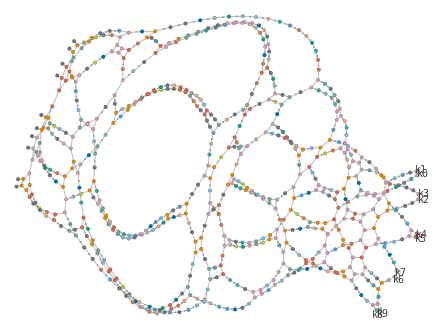

In [257]:
printTensorNetwork(circ)

In [274]:
tn = simplifyAndExtractCircuit(circ)

In [275]:
nodeInfo, converter = generateNodeInfoAndConverter(tn)

In [280]:
graph = makeTensorGraph(nodeInfo, converter)

/usr/local/lib/python3.8/dist-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


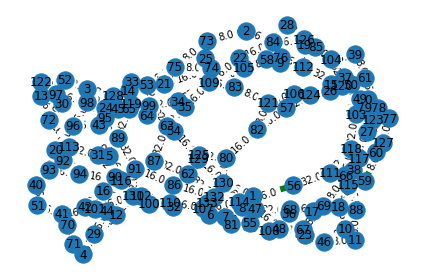

In [281]:
printGraph(graph)